In [20]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from model.bulkformer import BulkFormer, model_params

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [21]:
ckpt_path = "checkpoints/epoch_4.pt"   # or whichever epoch you want
state_dict = torch.load(ckpt_path, map_location="cpu")

import json

with open("checkpoints/config.json", "r") as f:
    cfg = json.load(f)

cfg

esm2_data = torch.load("./data/embeddings/esm2_t6_8M_UR50D_gene_embeddings.pt")
gene_emb = esm2_data["embeddings"].float()

edge_index = torch.load("./graph/edge_index_top20.pt").long()



In [22]:
import pandas as pd
from pathlib import Path

# ----------------------------
# Paths
# ----------------------------
data_dir = Path("data/tcga")
raw_dir = data_dir / "raw"
manifest_file = data_dir / "gdc_manifest.2025-11-16.123311.txt"
sample_sheet_file = data_dir / "gdc_sample_sheet.2025-11-16.tsv"

# ----------------------------
# Load manifest
# ----------------------------
manifest_df = pd.read_csv(manifest_file, sep="\t")
print(f"Manifest contains {len(manifest_df)} files")

# Manifest columns: id, filename, md5, size, state
# We need only id + filename
count_files = {}

for _, row in manifest_df.iterrows():
    file_id = row["id"]
    filename = row["filename"]

    file_path = raw_dir / file_id / filename

    if file_path.exists():
        count_files[file_id] = file_path
    else:
        print(f"Warning: Missing file: {file_id}")

print(f"\nFound {len(count_files)} of {len(manifest_df)} manifest entries")

# ----------------------------
# Load sample sheet (metadata)
# ----------------------------
sample_sheet_df = pd.read_csv(sample_sheet_file, sep="\t")
metadata = sample_sheet_df[["File ID", "Project ID", "Tissue Type"]].copy()
metadata.columns = ["file_id", "project_id", "tissue_type"]

print(f"Metadata loaded for {len(metadata)} samples")

# ----------------------------
# Merge file paths + metadata
# ----------------------------
file_mapping = pd.DataFrame(
    list(count_files.items()), 
    columns=["file_id", "file_path"]
)

file_mapping = file_mapping.merge(metadata, on="file_id", how="left")

# Save mapping
file_mapping.to_csv(data_dir / "file_mapping.csv", index=False)
metadata.to_csv(data_dir / "metadata.csv", index=False)

print("\nSaved file_mapping.csv and metadata.csv")
print(file_mapping.head())

# ----------------------------
# Load one count file to preview
# ----------------------------
if len(file_mapping):
    example_file = file_mapping.iloc[0]["file_path"]
    print(f"\nReading sample counts from:\n{example_file}\n")
    df_example = pd.read_csv(example_file, sep="\t", comment="#")
    # print(df_example.head())

df_example.head()


Manifest contains 3481 files

Found 3481 of 3481 manifest entries
Metadata loaded for 3481 samples

Saved file_mapping.csv and metadata.csv
                                file_id  \
0  9dc09c86-c728-4bd9-b2b6-2d9962dad662   
1  95668f0b-130d-44d4-94c0-ba7a4e7798e6   
2  461fda5d-d6e6-4354-b035-c302cc43b03f   
3  30ff778c-844b-4140-9025-7ab1938f10a9   
4  427a04c9-9b48-49de-8a47-2adc4e1dd32a   

                                           file_path project_id tissue_type  
0  data/tcga/raw/9dc09c86-c728-4bd9-b2b6-2d9962da...  TCGA-BRCA       Tumor  
1  data/tcga/raw/95668f0b-130d-44d4-94c0-ba7a4e77...  TCGA-BRCA       Tumor  
2  data/tcga/raw/461fda5d-d6e6-4354-b035-c302cc43...  TCGA-BRCA       Tumor  
3  data/tcga/raw/30ff778c-844b-4140-9025-7ab1938f...  TCGA-BRCA       Tumor  
4  data/tcga/raw/427a04c9-9b48-49de-8a47-2adc4e1d...  TCGA-BRCA       Tumor  

Reading sample counts from:
data/tcga/raw/9dc09c86-c728-4bd9-b2b6-2d9962dad662/d1f1743c-5fd9-4ae8-90c2-8c3e2d475d1b.rna_seq.augmente

,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded
0,N_unmapped,NaN,NaN,4313871,4313871,4313871,NaN,NaN,NaN
1,N_multimapping,NaN,NaN,9111078,9111078,9111078,NaN,NaN,NaN
2,N_noFeature,NaN,NaN,5923368,39711848,39910067,NaN,NaN,NaN
3,N_ambiguous,NaN,NaN,7420053,1883578,1872503,NaN,NaN,NaN
4,ENSG00000000003.15,TSPAN6,protein_coding,1984,953,1031,16.5243,7.4706,7.9838


In [23]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ----------------------------
# Paths
# ----------------------------
data_dir = Path("data/tcga")
raw_dir = data_dir / "raw"
manifest_file = data_dir / "gdc_manifest.2025-11-16.123311.txt"
sample_sheet_file = data_dir / "gdc_sample_sheet.2025-11-16.tsv"

# -----------------------------------------------------
# 1️⃣ Load manifest: (file_id, filename)
# -----------------------------------------------------
manifest_df = pd.read_csv(manifest_file, sep="\t")
print(f"Manifest contains {len(manifest_df)} files")

count_files = {}

for _, row in manifest_df.iterrows():
    file_id = row["id"]
    filename = row["filename"]

    file_path = raw_dir / file_id / filename
    if file_path.exists():
        count_files[file_id] = file_path
    else:
        print(f"Warning: Missing file: {file_id}")

print(f"Found {len(count_files)} files")

# -----------------------------------------------------
# 2️⃣ Load sample sheet metadata (project + tissue)
# -----------------------------------------------------
sample_sheet_df = pd.read_csv(sample_sheet_file, sep="\t")

metadata = sample_sheet_df[["File ID", "Project ID", "Tissue Type"]].copy()
metadata.columns = ["file_id", "project_id", "tissue_type"]

print(f"Metadata loaded for {len(metadata)} samples")

# Merge mapping + metadata
file_mapping = (
    pd.DataFrame(list(count_files.items()), columns=["file_id", "file_path"])
      .merge(metadata, on="file_id", how="left")
)

file_mapping.to_csv(data_dir / "file_mapping.csv", index=False)
print("\nSaved file_mapping.csv")
print(file_mapping.head())


# -----------------------------------------------------
# 3️⃣ Load safe gene list + canonical gene order
# -----------------------------------------------------
safe_path = Path("./data/archs4/processed_short_proteins/test_gene_order_short.csv")
safe_genes_df = pd.read_csv(safe_path)

# canonical input order (same as BulkFormer training)
canonical_order = safe_genes_df["gene_symbol"].tolist()
protein_coding_genes = set(canonical_order)

print(f"Loaded {len(canonical_order)} canonical protein-coding genes")


# -----------------------------------------------------
# 4️⃣ TCGA loader (unstranded counts only)
# -----------------------------------------------------
def load_tcga_counts(path, protein_gene_symbols, canonical_order):
    df = pd.read_csv(path, sep="\t", comment="#")

    # Keep only relevant rows
    df = df[df["gene_name"].notna()]

    # Filter to protein-coding
    df = df[df["gene_type"] == "protein_coding"]

    # Keep only canonical protein-coding set
    df = df[df["gene_name"].isin(protein_gene_symbols)]

    # Deduplicate: keep highest-count version of each gene
    df = df.sort_values("unstranded", ascending=False).drop_duplicates("gene_name")

    # Reindex into canonical ARCHS4 order
    df = df.set_index("gene_name").reindex(canonical_order)

    # Fill missing genes with zero
    df["unstranded"] = df["unstranded"].fillna(0)

    return df["unstranded"]



# -----------------------------------------------------
# 5️⃣ Process ALL samples into one big matrix
# -----------------------------------------------------
all_vectors = []
sample_ids = []

print("\nProcessing TCGA samples...")

j = 0 
for _, row in tqdm(file_mapping.iterrows(), total=len(file_mapping)):
    vec = load_tcga_counts(
        row["file_path"],
        protein_coding_genes,
        canonical_order
    )
    all_vectors.append(vec.values)
    sample_ids.append(row["file_id"])
    # j += 1
    # if j == 4:
    #     break

# Final matrix
X = pd.DataFrame(all_vectors, index=sample_ids, columns=canonical_order)

print("\nFinal matrix shape:", X.shape)

# -----------------------------------------------------
# 6️⃣ Save outputs
# -----------------------------------------------------
# X.to_parquet(data_dir / "tcga_unstranded_matrix.parquet", index=True)
# file_mapping.to_parquet(data_dir / "tcga_metadata.parquet", index=False)

print("\nSaved:")
print(" - tcga_unstranded_matrix.parquet")
print(" - tcga_metadata.parquet")



Manifest contains 3481 files
Found 3481 files
Metadata loaded for 3481 samples

Saved file_mapping.csv
                                file_id  \
0  9dc09c86-c728-4bd9-b2b6-2d9962dad662   
1  95668f0b-130d-44d4-94c0-ba7a4e7798e6   
2  461fda5d-d6e6-4354-b035-c302cc43b03f   
3  30ff778c-844b-4140-9025-7ab1938f10a9   
4  427a04c9-9b48-49de-8a47-2adc4e1dd32a   

                                           file_path project_id tissue_type  
0  data/tcga/raw/9dc09c86-c728-4bd9-b2b6-2d9962da...  TCGA-BRCA       Tumor  
1  data/tcga/raw/95668f0b-130d-44d4-94c0-ba7a4e77...  TCGA-BRCA       Tumor  
2  data/tcga/raw/461fda5d-d6e6-4354-b035-c302cc43...  TCGA-BRCA       Tumor  
3  data/tcga/raw/30ff778c-844b-4140-9025-7ab1938f...  TCGA-BRCA       Tumor  
4  data/tcga/raw/427a04c9-9b48-49de-8a47-2adc4e1d...  TCGA-BRCA       Tumor  
Loaded 19357 canonical protein-coding genes

Processing TCGA samples...

Saved file_mapping.csv
                                file_id  \
0  9dc09c86-c728-4bd9-b2b6-2d99

100%|██████████| 3481/3481 [04:59<00:00, 11.63it/s]




Final matrix shape: (3481, 19357)

Saved:
 - tcga_unstranded_matrix.parquet
 - tcga_metadata.parquet


Vector shape: (19357,)
First 20 values: [1.11768e+05 9.10330e+04 3.17667e+05 1.30943e+05 5.36500e+03 7.18020e+04
 1.50848e+05 3.21440e+04 1.60980e+04 2.32291e+05 1.11010e+05 3.55900e+04
 1.22547e+05 0.00000e+00 2.47700e+03 0.00000e+00 3.70800e+03 1.60000e+01
 2.74900e+03 3.22300e+03]
MT-ND1                111768.0
MT-ND2                91033.0
MT-CO1                317667.0
MT-CO2                130943.0
MT-ATP8               5365.0
MT-ATP6               71802.0
MT-CO3                150848.0
MT-ND3                32144.0
MT-ND4L               16098.0
MT-ND4                232291.0
MT-ND5                111010.0
MT-ND6                35590.0
MT-CYB                122547.0
MAFIP                 0.0
RYBP                  2477.0
GCGR                  0.0
MCRIP1                3708.0
ACR                   16.0
C8orf33               2749.0
SHANK3                3223.0


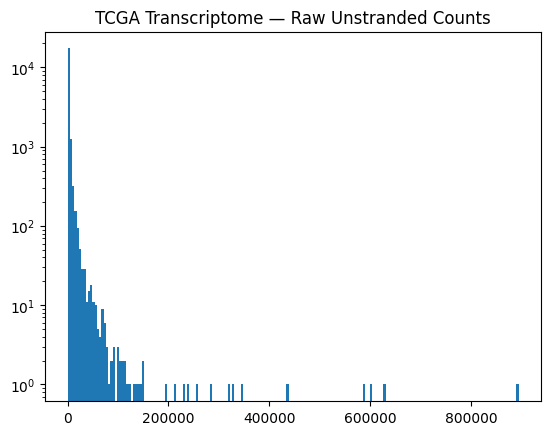

In [24]:

from tqdm import tqdm


i = 3   # choose the first sample
x = all_vectors[i]   # this is a 1D array of expression values
print("Vector shape:", x.shape)
print("First 20 values:", x[:20])

canonical_order[:20]

for gene, val in zip(canonical_order[:20], x[:20]):
    print(f"{gene:20s}  {val}")

import pandas as pd

df_view = pd.DataFrame({
    "gene": canonical_order,
    "unstranded_count": x
})

df_view.head(20)

df_view["unstranded_count"].describe()

(df_view["unstranded_count"] == 0).sum()


import matplotlib.pyplot as plt

plt.hist(df_view["unstranded_count"], bins=200)
plt.yscale("log")
plt.title("TCGA Transcriptome — Raw Unstranded Counts")
plt.show()




In [25]:
# Choose any sample index you want
i = 0  
sample_id = sample_ids[i]
sample_path = file_mapping[file_mapping["file_id"] == sample_id]["file_path"].values[0]

raw_df = pd.read_csv(sample_path, sep="\t", comment="#")
raw_df["gene_name"] = raw_df["gene_name"].astype(str)

processed_vec = all_vectors[i]

df_proc = pd.DataFrame({
    "gene_name": canonical_order,
    "processed_unstranded": processed_vec
})

raw_pc = raw_df[
    (raw_df["gene_type"] == "protein_coding") &
    (raw_df["gene_name"].isin(canonical_order))
].copy()

# deduplicate by highest unstranded count
raw_pc = (
    raw_pc.sort_values("unstranded", ascending=False)
          .drop_duplicates("gene_name")
)
raw_pc = raw_pc[["gene_name", "unstranded"]]

compare = df_proc.merge(raw_pc, on="gene_name", how="left")
compare["unstranded"] = compare["unstranded"].fillna(0)

print(compare.sample(20))


      gene_name  processed_unstranded  unstranded
14775   SLC27A6                 161.0       161.0
12857      ARF5                6172.0      6172.0
11620   TXNDC11                5177.0      5177.0
19130     C4BPA                  12.0        12.0
1114       OCA2                   4.0         4.0
15120    BDKRB2                 801.0       801.0
15013      ROS1                   0.0         0.0
2084      MYO10                 874.0       874.0
15023   SLC17A4                   0.0         0.0
13859      ELOA                2737.0      2737.0
2467      ZNF98                  54.0        54.0
11808      CAV2                2042.0      2042.0
6527      RXFP4                   1.0         1.0
18249     GSTK1               10114.0     10114.0
1863       PHEX                  86.0        86.0
17667      DUS2                 489.0       489.0
11060      WNK1               13513.0     13513.0
16559     FFAR3                   2.0         2.0
3106      PEX39                   0.0         0.0


In [11]:
# -----------------------------------------------------
# 1️⃣ Load TRUE exon-based gene lengths from GENCODE
# -----------------------------------------------------
# This file contains:
#    gene_symbol, exon_length_bp, seq_len (protein AA length)
# We use exon_length_bp for TPM normalization (NOT protein length).
seq_df = pd.read_csv("data/gencode/canonical_genes_with_exon_lengths_safe_sequences.csv")

print(seq_df.columns)
# Expected columns: ["gene_symbol", "exon_length_bp", "seq_len"]

# Build gene-length dictionary using TRUE merged exon lengths (in bp)
gene_length_dict = {
    row["gene_symbol"]: row["exon_length_bp"]
    for _, row in seq_df.iterrows()
}

print("Loaded gene lengths for:", len(gene_length_dict))


# -----------------------------------------------------
# 2️⃣ TPM normalization function
# -----------------------------------------------------
import numpy as np
import pandas as pd

def normalize_to_tpm(X_df, gene_length_dict):
    """
    Normalize raw RNA-seq counts to log(TPM+1).

    Parameters
    ----------
    X_df : DataFrame
        Samples × genes matrix of raw unstranded counts.
    gene_length_dict : dict
        gene_symbol → merged exon length in base pairs (bp).

    Why exon length?
      TPM is defined as:
          counts_per_kb / sum(counts_per_kb) * 1e6
      Only exons contribute to mRNA abundance, so exon span is the
      correct denominator (not protein length or genomic span).
    """

    gene_names = X_df.columns

    # Convert lengths to kilobases for TPM formula
    gene_len_kb = np.array([
        gene_length_dict.get(g, 1000) / 1000.0   # fallback = 1kb
        for g in gene_names
    ])

    counts = X_df.values  # shape: samples × genes

    # counts per kilobase
    rate = counts / gene_len_kb

    # per-sample scaling factor
    sum_per_sample = rate.sum(axis=1, keepdims=True)
    sum_per_sample[sum_per_sample == 0] = 1e-6

    # TPM = (rate / total_rate) * 1e6
    tpm = rate / sum_per_sample * 1e6

    # log(TPM + 1)
    log_tpm = np.log1p(tpm)

    return pd.DataFrame(log_tpm, index=X_df.index, columns=X_df.columns)


# -----------------------------------------------------
# 3️⃣ Compute TPM for entire transcriptome matrix
# -----------------------------------------------------
X_tpm = normalize_to_tpm(X, gene_length_dict)
print(X_tpm.head())


# -----------------------------------------------------
# 4️⃣ Compare our TPM vs TCGA TPM for one sample
# -----------------------------------------------------
i = 0
sample_id = X.index[i]

sample_path = file_mapping.loc[file_mapping["file_id"] == sample_id, "file_path"].values[0]

raw_df = pd.read_csv(sample_path, sep="\t", comment="#")

# Keep only canonical protein-coding genes
raw_df = raw_df[raw_df["gene_name"].isin(canonical_order)]
raw_df = raw_df[raw_df["gene_type"] == "protein_coding"]

# Deduplicate: keep highest-count entry per gene
raw_df = (
    raw_df.sort_values("unstranded", ascending=False)
          .drop_duplicates("gene_name")
)

# TCGA-provided TPM (ground truth)
raw_tpm = raw_df.set_index("gene_name")["tpm_unstranded"]
raw_tpm = raw_tpm.reindex(canonical_order).fillna(0)

# Our TPM (undo log)
our_tpm = np.expm1(X_tpm.loc[sample_id])


# -----------------------------------------------------
# 5️⃣ Correlation sanity check
# -----------------------------------------------------
print("Pearson correlation:", np.corrcoef(our_tpm, raw_tpm)[0, 1])


Index(['gene_symbol', 'seq_len', 'exon_length_bp'], dtype='object')
Loaded gene lengths for: 19357
Loaded gene lengths for: 19357
                                         MT-ND1     MT-ND2     MT-CO1  \
9dc09c86-c728-4bd9-b2b6-2d9962dad662  10.083367  10.096234  10.730359   
95668f0b-130d-44d4-94c0-ba7a4e7798e6   8.217146   8.279439   8.992029   
461fda5d-d6e6-4354-b035-c302cc43b03f   9.249208   9.545273   9.847769   
30ff778c-844b-4140-9025-7ab1938f10a9   9.047924   8.756621   9.614374   
427a04c9-9b48-49de-8a47-2adc4e1dd32a   8.458643   9.028074   9.607067   

                                         MT-CO2   MT-ATP8   MT-ATP6  \
9dc09c86-c728-4bd9-b2b6-2d9962dad662  10.731193  9.064085  9.884531   
95668f0b-130d-44d4-94c0-ba7a4e7798e6   8.966936  7.519133  8.647694   
461fda5d-d6e6-4354-b035-c302cc43b03f   9.606361  7.510456  9.182621   
30ff778c-844b-4140-9025-7ab1938f10a9   9.541015  7.541847  8.944619   
427a04c9-9b48-49de-8a47-2adc4e1dd32a   9.735296  7.920365  8.909150   

    

In [12]:
print("Raw TCGA TPM stats:")
print(raw_tpm.describe())

print("\nOur computed TPM stats:")
print(pd.Series(our_tpm).describe())

compare_df = pd.DataFrame({
    "raw_tpm": raw_tpm,
    "our_tpm": our_tpm
})

print(compare_df.sample(15))

print("Correlation:", compare_df.corr().iloc[0,1])


Raw TCGA TPM stats:
count    19357.000000
mean        40.143047
std        645.863900
min          0.000000
25%          0.298000
50%          4.839600
75%         18.183800
max      40001.690300
Name: tpm_unstranded, dtype: float64

Our computed TPM stats:
count    19357.000000
mean        51.660898
std        737.613374
min          0.000000
25%          0.362215
50%          6.239883
75%         24.628934
max      45760.248838
Name: 9dc09c86-c728-4bd9-b2b6-2d9962dad662, dtype: float64
           raw_tpm    our_tpm
H4C3        1.5858   1.814088
MPPED2      2.2353   2.602522
TMEM222    29.3642  64.008225
TNFRSF13C   2.8409   3.181757
SLC29A1    36.8740  21.430188
AVP         0.0000   0.000000
OR1L3       0.0000   0.000000
PIGV       11.1562   9.315098
LCNL1       0.0839   0.184167
N4BP2L2    13.3240  25.373772
OXCT1      15.1670  17.435485
GALNS      12.1495  35.258139
TNFRSF9     0.9989   1.234379
CCDC163     3.5080   4.835577
SLFN11      8.1975   8.129989
Correlation: 0.989399985070

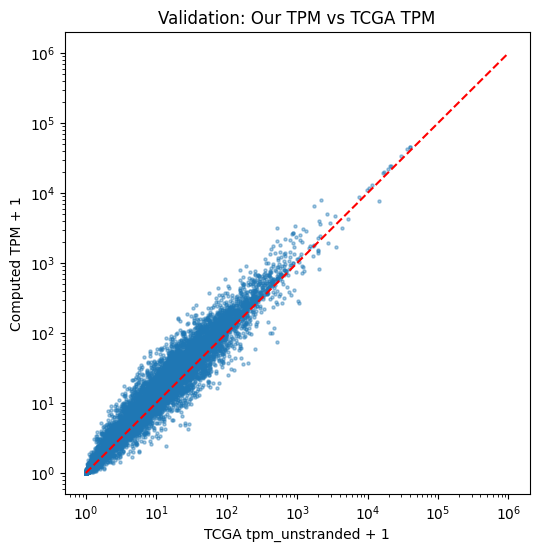

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(raw_tpm + 1, our_tpm + 1, s=5, alpha=0.4)
plt.xscale("log")
plt.yscale("log")

plt.plot([1, 1e6], [1, 1e6], 'r--')  # diagonal

plt.xlabel("TCGA tpm_unstranded + 1")
plt.ylabel("Computed TPM + 1")
plt.title("Validation: Our TPM vs TCGA TPM")
plt.show()


In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import numpy as np

def extract_feature(expr_array, 
                    high_var_gene_idx,
                    feature_type,
                    aggregate_type,
                    device,
                    batch_size,
                    model,
                    return_expr_value = False,
                    esm2_emb = None,
                    valid_gene_idx = None):
    """
    Extracts transcriptome-level or gene-level feature representations from input expression profiles
    using a pre-trained deep learning model.

    Parameters
    ----------
    expr_array : np.ndarray
        A NumPy array of shape [N_samples, N_genes] representing gene expression profiles
        (e.g., log-transformed TPM values).

    high_var_gene_idx : list or np.ndarray
        Indices of highly variable genes used for transcriptome-level embedding aggregation.

    feature_type : str
        Specifies the type of feature to extract. Options:
            - 'transcriptome_level': aggregate gene embeddings to a single sample-level vector.
            - 'gene_level': retain per-gene embeddings for downstream fusion with external embeddings (e.g., ESM2).

    aggregate_type : str
        Aggregation method used when `feature_type='transcriptome_level'`. Options include:
            - 'max': use maximum value across selected genes.
            - 'mean': use average value.
            - 'median': use median value.
            - 'all': combine all three strategies by summation.

    device : torch.device or str
        Computation device (e.g., 'cuda' or 'cpu') for model inference.

    batch_size : int
        Number of samples per batch during feature extraction.

    model : torch.nn.Module
        The pre-trained model to use for feature extraction.

    return_expr_value : bool, optional
        If True, return predicted gene expression values instead of extracted embeddings. Default is False.

    esm2_emb : torch.Tensor, optional
        Precomputed ESM2 embeddings for all genes, used in gene-level feature concatenation.
        Required if `feature_type='gene_level'`.

    valid_gene_idx : list or np.ndarray, optional
        Indices of valid genes to be retained in gene-level embedding extraction.

    Returns
    -------
    result_emb : torch.Tensor
        The extracted feature representations:
            - [N_samples, D] for transcriptome-level features.
            - [N_samples, N_genes, D_concat] for gene-level features with ESM2 concatenation.

    or (if `return_expr_value=True`)
    expr_predictions : np.ndarray
        Model-predicted expression profiles for all samples.
    """

    expr_tensor = torch.tensor(expr_array, dtype=torch.float32, device=device)
    mydataset = TensorDataset(expr_tensor)
    myloader = DataLoader(mydataset, batch_size=batch_size, shuffle=False) 
    model.eval()

    all_emb_list = []
    all_expr_value_list = []

    # Get the last layer index (gb_repeat - 1)
    last_layer_idx = len(model.gb_formers) - 1

    with torch.no_grad():
        if feature_type == 'transcriptome_level':
            for (X,) in tqdm(myloader, total=len(myloader)):
                X = X.to(device)
                output, emb = model(X, [last_layer_idx])
                all_expr_value_list.append(output.detach().cpu().numpy())
                emb = emb[last_layer_idx].detach().cpu().numpy()
                emb_valid = emb[:, high_var_gene_idx, :]
 
                if aggregate_type == 'max':
                    final_emb = np.max(emb_valid, axis=1)
                elif aggregate_type == 'mean':
                    final_emb = np.mean(emb_valid, axis=1)
                elif aggregate_type == 'median':
                    final_emb = np.median(emb_valid, axis=1)
                elif aggregate_type == 'all':
                    max_emb = np.max(emb_valid, axis=1)
                    mean_emb = np.mean(emb_valid, axis=1)
                    median_emb = np.median(emb_valid, axis=1)
                    final_emb = max_emb + mean_emb + median_emb

                all_emb_list.append(final_emb)
            result_emb = np.vstack(all_emb_list)
            result_emb = torch.tensor(result_emb, device='cpu', dtype=torch.float32)

        elif feature_type == 'gene_level':
            for (X,) in tqdm(myloader, total=len(myloader)):
                X = X.to(device)
                output, emb = model(X, [last_layer_idx])
                emb = emb[last_layer_idx].detach().cpu().numpy()
                emb_valid = emb[:, valid_gene_idx, :]
                all_emb_list.append(emb_valid)
                all_expr_value_list.append(output.detach().cpu().numpy())
            all_emb = np.vstack(all_emb_list)
            all_emb_tensor = torch.tensor(all_emb, device='cpu', dtype=torch.float32)
            esm2_emb_selected = esm2_emb[valid_gene_idx]
            esm2_emb_expanded = esm2_emb_selected.unsqueeze(0).expand(all_emb_tensor.shape[0], -1, -1) 
            esm2_emb_expanded = esm2_emb_expanded.to('cpu')

            result_emb = torch.cat([all_emb_tensor, esm2_emb_expanded], dim=-1)
    
    if return_expr_value:
        return np.vstack(all_expr_value_list)
    else:
        return result_emb


In [ ]:
# Prepare input data
input_df = X_tpm  # Use the TPM-normalized matrix from cell 6
edge_index = edge_index.to(device)

# Load the model
model = BulkFormer(
    dim=cfg["dim"],
    graph=edge_index,
    gene_emb=gene_emb,
    gene_length=cfg["num_genes"],
    bin_head=cfg["bin_head"],
    full_head=cfg["full_head"],
    bins=cfg["bins"],
    gb_repeat=cfg["gb_repeat"],
    p_repeat=cfg["p_repeat"],
)
model.load_state_dict(state_dict)
model = model.to(device)

# Define high variance genes and valid gene indices
# Using all genes as valid for now - you can filter these based on your criteria
high_var_gene_idx = list(range(len(canonical_order)))
valid_gene_idx = list(range(len(canonical_order)))

# Update model_params to include gene_emb
model_params['gene_emb'] = gene_emb

# Extract transcriptome-level embedding
res1 = extract_feature(
    expr_array=input_df.values,
    high_var_gene_idx=high_var_gene_idx,
    feature_type='transcriptome_level',
    aggregate_type='max',
    device=device,
    batch_size=4,
    model=model,
    return_expr_value=False,
    esm2_emb=model_params['gene_emb'],
    valid_gene_idx=valid_gene_idx
)

res1.shape

100%|██████████| 871/871 [04:41<00:00,  3.09it/s]


torch.Size([3481, 320])

: 

In [ ]:
# Extract gene-level embedding
res2 = extract_feature(
    expr_array=input_df.values,
    high_var_gene_idx=high_var_gene_idx,
    feature_type='gene_level',
    aggregate_type='max',  # Changed from 'all' to 'max' - aggregate_type is ignored for gene_level
    device=device,
    batch_size=4,
    model=model,
    return_expr_value=False,
    esm2_emb=gene_emb,  # Use gene_emb directly instead of model_params['gene_emb']
    valid_gene_idx=valid_gene_idx
)

res2.shape

 56%|█████▋    | 491/871 [05:26<06:50,  1.08s/it]

In [15]:
# Load metadata (matches the file_mapping created earlier)
meta = file_mapping[['file_id', 'project_id', 'tissue_type']].copy()
meta.columns = ['sample_id', 'project_id', 'tissue_type']

# X_tpm uses file_id as index, so align metadata
meta = meta.set_index('sample_id')

# Verify alignment
assert set(meta.index) >= set(X_tpm.index), "Metadata doesn't cover all samples"

print(f"Metadata loaded: {len(meta)} samples")
meta.head()


Metadata loaded: 3481 samples


,project_id,tissue_type
sample_id,,
9dc09c86-c728-4bd9-b2b6-2d9962dad662,TCGA-BRCA,Tumor
95668f0b-130d-44d4-94c0-ba7a4e7798e6,TCGA-BRCA,Tumor
461fda5d-d6e6-4354-b035-c302cc43b03f,TCGA-BRCA,Tumor
30ff778c-844b-4140-9025-7ab1938f10a9,TCGA-BRCA,Tumor
427a04c9-9b48-49de-8a47-2adc4e1dd32a,TCGA-BRCA,Tumor


In [16]:
# Already aligned in previous cell, just verify
print(f"Metadata shape: {meta.shape}")
print(f"Expression matrix shape: {X_tpm.shape}")
print(f"\nSample counts by project:")
print(meta['project_id'].value_counts())


Metadata shape: (3481, 2)
Expression matrix shape: (3481, 19357)

Sample counts by project:
project_id
TCGA-BRCA    1231
TCGA-KIRC     614
TCGA-LUAD     601
TCGA-LUSC     562
TCGA-SKCM     473
Name: count, dtype: int64


In [ ]:
# Select two cancer types for comparison
A = "TCGA-BRCA"  # Breast cancer
B = "TCGA-LUAD"  # Lung adenocarcinoma

samples_A = meta[meta.project_id == A].index.tolist()
samples_B = meta[meta.project_id == B].index.tolist()

print(f"{A}: {len(samples_A)} samples")
print(f"{B}: {len(samples_B)} samples")

# Balance the cohorts
n = min(len(samples_A), len(samples_B))
samples_A = samples_A[:n]
samples_B = samples_B[:n]

subset_samples = samples_A + samples_B
print(f"\nBalanced subset: {len(subset_samples)} samples ({n} per group)")

# Create subset expression matrix (samples × genes)
X_sub = X_tpm.loc[subset_samples].values
print(f"X_sub shape: {X_sub.shape}")


TCGA-BRCA: 1231 samples
TCGA-LUAD: 601 samples

Balanced subset: 1202 samples (601 per group)
X_sub shape: (1202, 19357)


In [30]:
import numpy as np
from scipy.stats import pearsonr, spearmanr


def evaluate_imputation(model, X_tpm, masking_ratio=0.15, device="cuda"):
    """
    Mask gene expression values in log(TPM+1) space,
    perform prediction, and evaluate PCC/SCC on masked genes.
    """

    # Handle both DataFrame and ndarray inputs
    X = X_tpm.values.copy() if hasattr(X_tpm, 'values') else X_tpm.copy()
    N, G = X.shape

    # mask random genes
    mask = np.random.rand(N, G) < masking_ratio
    X_masked = X.copy()
    X_masked[mask] = 0.0

    # run model to predict gene expression
    preds = extract_feature(
        expr_array=X_masked,
        high_var_gene_idx=list(range(G)),
        feature_type='transcriptome_level',
        aggregate_type='max',
        device=device,
        batch_size=16,
        model=model,
        return_expr_value=True  # return expression predictions
    )

    true_vals = X[mask]
    pred_vals = preds[mask]

    pcc = pearsonr(true_vals, pred_vals)[0]
    scc = spearmanr(true_vals, pred_vals)[0]

    return pcc, scc


# Ensure edge_index is on the correct device before model construction
edge_index = edge_index.to(device)

# Load the model
model = BulkFormer(
    dim=cfg["dim"],
    graph=edge_index,
    gene_emb=gene_emb.to(device),
    gene_length=cfg["num_genes"],
    bin_head=cfg["bin_head"],
    full_head=cfg["full_head"],
    bins=cfg["bins"],
    gb_repeat=cfg["gb_repeat"],
    p_repeat=cfg["p_repeat"],
)
model.load_state_dict(state_dict)
model = model.to(device)

# ---- Run example imputation test ----
pcc, scc = evaluate_imputation(model, X_sub)
print("Imputation PCC:", pcc)
print("Imputation Spearman:", scc)


100%|██████████| 76/76 [01:39<00:00,  1.31s/it]



Imputation PCC: 0.806855870373835
Imputation Spearman: 0.8155992615652311


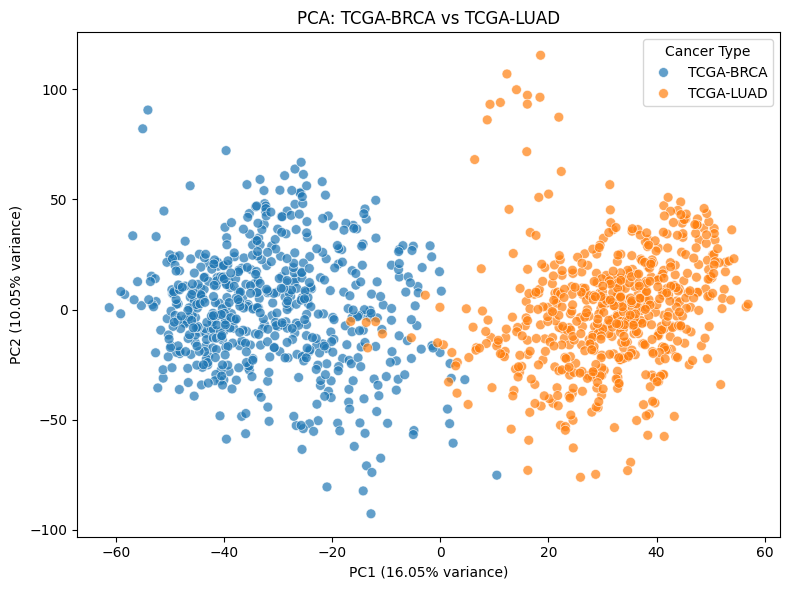

In [31]:
import seaborn as sns
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Perform PCA on the balanced subset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sub)

# Create labels for coloring
labels = [A] * n + [B] * n

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, alpha=0.7, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title(f'PCA: {A} vs {B}')
plt.legend(title='Cancer Type')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt

# Perform PCA on raw TPM values (convert from log(TPM+1) back to TPM)
X_raw_tpm = np.expm1(X_sub)  # expm1 is inverse of log1p

pca_raw = PCA(n_components=2)
X_pca_raw = pca_raw.fit_transform(X_raw_tpm)

# Also compute PCA on log(TPM+1) for comparison
pca_log = PCA(n_components=2)
X_pca_log = pca_log.fit_transform(X_sub)

# Create labels
labels = [A] * n + [B] * n

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Raw TPM
sns.scatterplot(x=X_pca_raw[:, 0], y=X_pca_raw[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[0])
axes[0].set_xlabel(f'PC1 ({pca_raw.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_raw.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'PCA on Raw TPM: {A} vs {B}')
axes[0].legend(title='Cancer Type')

# Plot 2: log(TPM+1)
sns.scatterplot(x=X_pca_log[:, 0], y=X_pca_log[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[1])
axes[1].set_xlabel(f'PC1 ({pca_log.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_log.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title(f'PCA on log(TPM+1): {A} vs {B}')
axes[1].legend(title='Cancer Type')

plt.tight_layout()
plt.show()

print(f"\nRaw TPM - PC1: {pca_raw.explained_variance_ratio_[0]:.2%}, PC2: {pca_raw.explained_variance_ratio_[1]:.2%}")
print(f"log(TPM+1) - PC1: {pca_log.explained_variance_ratio_[0]:.2%}, PC2: {pca_log.explained_variance_ratio_[1]:.2%}")

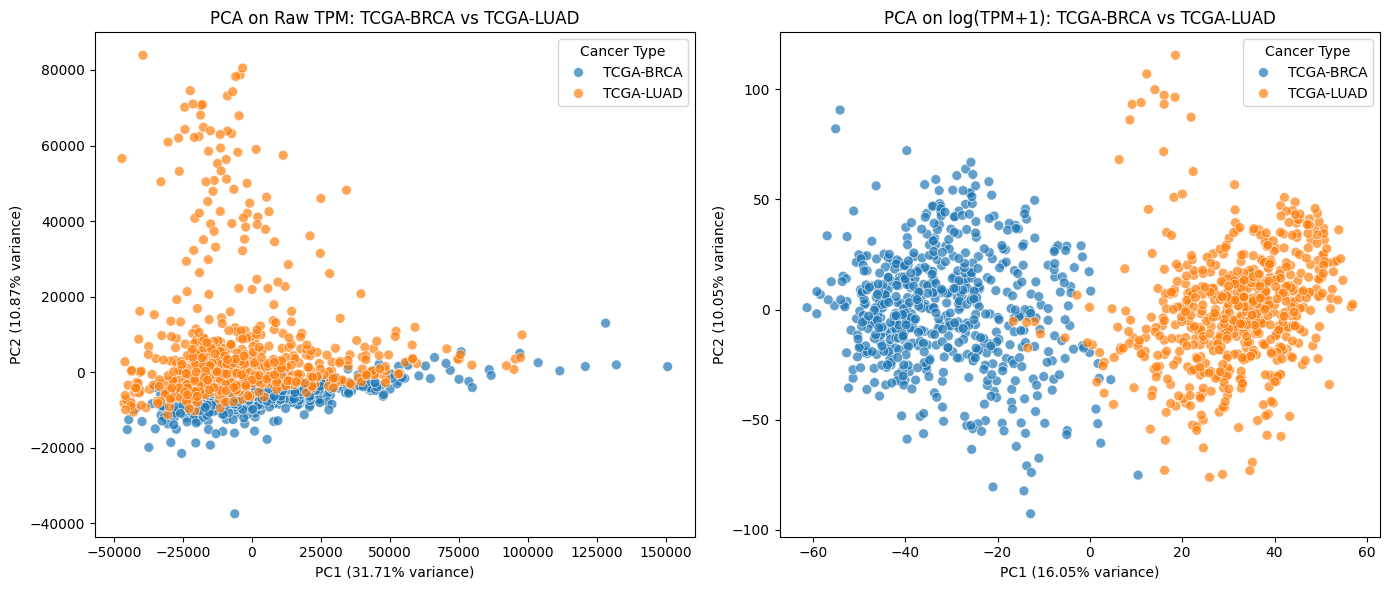


Raw TPM - PC1: 31.71%, PC2: 10.87%
log(TPM+1) - PC1: 16.05%, PC2: 10.05%


In [32]:
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt

# Perform PCA on raw TPM values (convert from log(TPM+1) back to TPM)
X_raw_tpm = np.expm1(X_sub)  # expm1 is inverse of log1p

pca_raw = PCA(n_components=2)
X_pca_raw = pca_raw.fit_transform(X_raw_tpm)

# Also compute PCA on log(TPM+1) for comparison
pca_log = PCA(n_components=2)
X_pca_log = pca_log.fit_transform(X_sub)

# Create labels
labels = [A] * n + [B] * n

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Raw TPM
sns.scatterplot(x=X_pca_raw[:, 0], y=X_pca_raw[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[0])
axes[0].set_xlabel(f'PC1 ({pca_raw.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_raw.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'PCA on Raw TPM: {A} vs {B}')
axes[0].legend(title='Cancer Type')

# Plot 2: log(TPM+1)
sns.scatterplot(x=X_pca_log[:, 0], y=X_pca_log[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[1])
axes[1].set_xlabel(f'PC1 ({pca_log.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_log.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title(f'PCA on log(TPM+1): {A} vs {B}')
axes[1].legend(title='Cancer Type')

plt.tight_layout()
plt.show()

print(f"\nRaw TPM - PC1: {pca_raw.explained_variance_ratio_[0]:.2%}, PC2: {pca_raw.explained_variance_ratio_[1]:.2%}")
print(f"log(TPM+1) - PC1: {pca_log.explained_variance_ratio_[0]:.2%}, PC2: {pca_log.explained_variance_ratio_[1]:.2%}")

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt

# res1 is the transcriptome-level embedding from cell 10
# It has shape [N_samples, embedding_dim]
sample_embs = res1.numpy()

# Perform PCA on sample embeddings
pca_emb = PCA(n_components=2)
X_pca_emb = pca_emb.fit_transform(sample_embs)

# Create labels for the balanced subset
labels = [A] * n + [B] * n

# Create a 3-panel comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Raw TPM PCA
sns.scatterplot(x=X_pca_raw[:, 0], y=X_pca_raw[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[0])
axes[0].set_xlabel(f'PC1 ({pca_raw.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_raw.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'PCA on Raw TPM: {A} vs {B}')
axes[0].legend(title='Cancer Type')

# Plot 2: log(TPM+1) PCA
sns.scatterplot(x=X_pca_log[:, 0], y=X_pca_log[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[1])
axes[1].set_xlabel(f'PC1 ({pca_log.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_log.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title(f'PCA on log(TPM+1): {A} vs {B}')
axes[1].legend(title='Cancer Type')

# Plot 3: Sample Embedding PCA
sns.scatterplot(x=X_pca_emb[:, 0], y=X_pca_emb[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[2])
axes[2].set_xlabel(f'PC1 ({pca_emb.explained_variance_ratio_[0]:.2%} variance)')
axes[2].set_ylabel(f'PC2 ({pca_emb.explained_variance_ratio_[1]:.2%} variance)')
axes[2].set_title(f'PCA on BulkFormer Embeddings: {A} vs {B}')
axes[2].legend(title='Cancer Type')

plt.tight_layout()
plt.show()

print(f"\nRaw TPM - PC1: {pca_raw.explained_variance_ratio_[0]:.2%}, PC2: {pca_raw.explained_variance_ratio_[1]:.2%}")
print(f"log(TPM+1) - PC1: {pca_log.explained_variance_ratio_[0]:.2%}, PC2: {pca_log.explained_variance_ratio_[1]:.2%}")
print(f"BulkFormer Embeddings - PC1: {pca_emb.explained_variance_ratio_[0]:.2%}, PC2: {pca_emb.explained_variance_ratio_[1]:.2%}")

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt

# Extract embeddings for the balanced subset
sample_embs_subset = extract_feature(
	expr_array=X_sub,
	high_var_gene_idx=high_var_gene_idx,
	feature_type='transcriptome_level',
	aggregate_type='max',
	device=device,
	batch_size=4,
	model=model,
	return_expr_value=False,
	esm2_emb=gene_emb,
	valid_gene_idx=valid_gene_idx
).numpy()

# Perform PCA on sample embeddings
pca_emb = PCA(n_components=2)
X_pca_emb = pca_emb.fit_transform(sample_embs_subset)

# Create labels for the balanced subset
labels = [A] * n + [B] * n

# Create a 3-panel comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Raw TPM PCA
sns.scatterplot(x=X_pca_raw[:, 0], y=X_pca_raw[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[0])
axes[0].set_xlabel(f'PC1 ({pca_raw.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_raw.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'PCA on Raw TPM: {A} vs {B}')
axes[0].legend(title='Cancer Type')

# Plot 2: log(TPM+1) PCA
sns.scatterplot(x=X_pca_log[:, 0], y=X_pca_log[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[1])
axes[1].set_xlabel(f'PC1 ({pca_log.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_log.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title(f'PCA on log(TPM+1): {A} vs {B}')
axes[1].legend(title='Cancer Type')

# Plot 3: Sample Embedding PCA
sns.scatterplot(x=X_pca_emb[:, 0], y=X_pca_emb[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[2])
axes[2].set_xlabel(f'PC1 ({pca_emb.explained_variance_ratio_[0]:.2%} variance)')
axes[2].set_ylabel(f'PC2 ({pca_emb.explained_variance_ratio_[1]:.2%} variance)')
axes[2].set_title(f'PCA on BulkFormer Embeddings: {A} vs {B}')
axes[2].legend(title='Cancer Type')

plt.tight_layout()
plt.show()

print(f"\nRaw TPM - PC1: {pca_raw.explained_variance_ratio_[0]:.2%}, PC2: {pca_raw.explained_variance_ratio_[1]:.2%}")
print(f"log(TPM+1) - PC1: {pca_log.explained_variance_ratio_[0]:.2%}, PC2: {pca_log.explained_variance_ratio_[1]:.2%}")
print(f"BulkFormer Embeddings - PC1: {pca_emb.explained_variance_ratio_[0]:.2%}, PC2: {pca_emb.explained_variance_ratio_[1]:.2%}")

NameError: name 'res1' is not defined

100%|██████████| 301/301 [04:34<00:00,  1.09it/s]



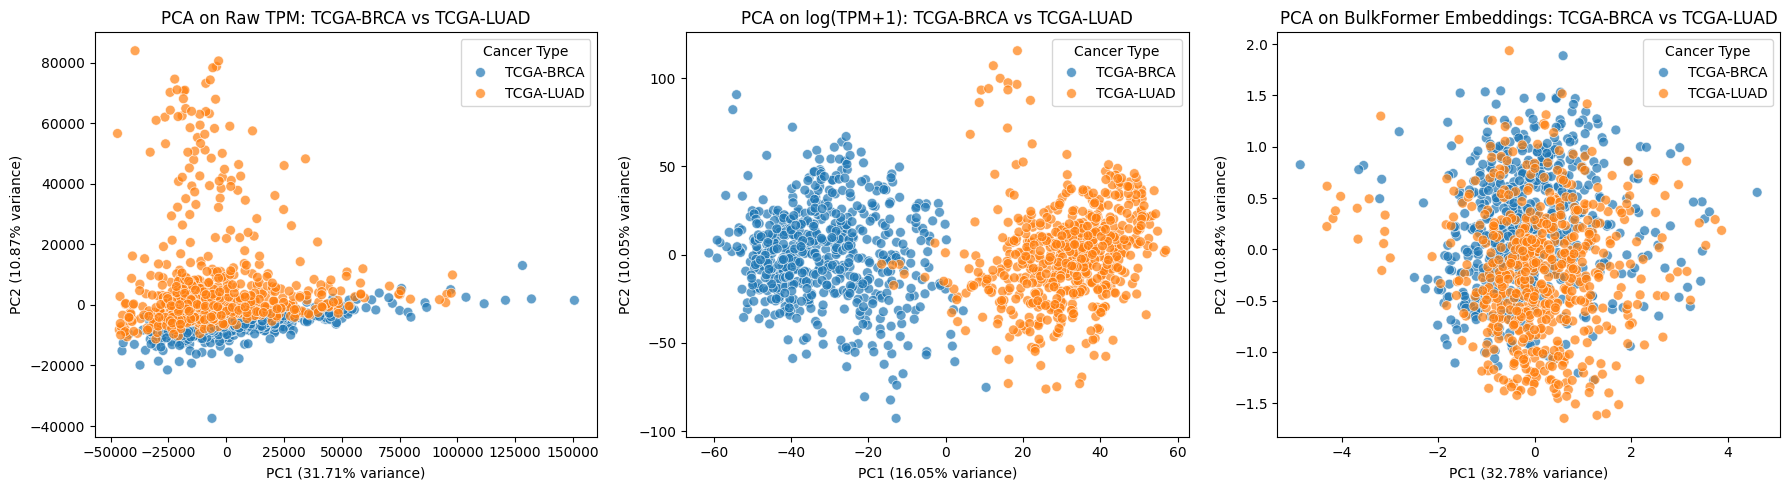


Raw TPM - PC1: 31.71%, PC2: 10.87%
log(TPM+1) - PC1: 16.05%, PC2: 10.05%
BulkFormer Embeddings - PC1: 32.78%, PC2: 10.84%


In [36]:
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt

# Define high variance genes and valid gene indices (using all genes)
high_var_gene_idx = list(range(len(canonical_order)))
valid_gene_idx = list(range(len(canonical_order)))

# Extract embeddings for the balanced subset
sample_embs_subset = extract_feature(
	expr_array=X_sub,
	high_var_gene_idx=high_var_gene_idx,
	feature_type='transcriptome_level',
	aggregate_type='max',
	device=device,
	batch_size=4,
	model=model,
	return_expr_value=False,
	esm2_emb=gene_emb,
	valid_gene_idx=valid_gene_idx
).numpy()

# Perform PCA on sample embeddings
pca_emb = PCA(n_components=2)
X_pca_emb = pca_emb.fit_transform(sample_embs_subset)

# Create labels for the balanced subset
labels = [A] * n + [B] * n

# Create a 3-panel comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Raw TPM PCA
sns.scatterplot(x=X_pca_raw[:, 0], y=X_pca_raw[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[0])
axes[0].set_xlabel(f'PC1 ({pca_raw.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_raw.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'PCA on Raw TPM: {A} vs {B}')
axes[0].legend(title='Cancer Type')

# Plot 2: log(TPM+1) PCA
sns.scatterplot(x=X_pca_log[:, 0], y=X_pca_log[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[1])
axes[1].set_xlabel(f'PC1 ({pca_log.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_log.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title(f'PCA on log(TPM+1): {A} vs {B}')
axes[1].legend(title='Cancer Type')

# Plot 3: Sample Embedding PCA
sns.scatterplot(x=X_pca_emb[:, 0], y=X_pca_emb[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[2])
axes[2].set_xlabel(f'PC1 ({pca_emb.explained_variance_ratio_[0]:.2%} variance)')
axes[2].set_ylabel(f'PC2 ({pca_emb.explained_variance_ratio_[1]:.2%} variance)')
axes[2].set_title(f'PCA on BulkFormer Embeddings: {A} vs {B}')
axes[2].legend(title='Cancer Type')

plt.tight_layout()
plt.show()

print(f"\nRaw TPM - PC1: {pca_raw.explained_variance_ratio_[0]:.2%}, PC2: {pca_raw.explained_variance_ratio_[1]:.2%}")
print(f"log(TPM+1) - PC1: {pca_log.explained_variance_ratio_[0]:.2%}, PC2: {pca_log.explained_variance_ratio_[1]:.2%}")
print(f"BulkFormer Embeddings - PC1: {pca_emb.explained_variance_ratio_[0]:.2%}, PC2: {pca_emb.explained_variance_ratio_[1]:.2%}")

100%|██████████| 301/301 [01:26<00:00,  3.49it/s]



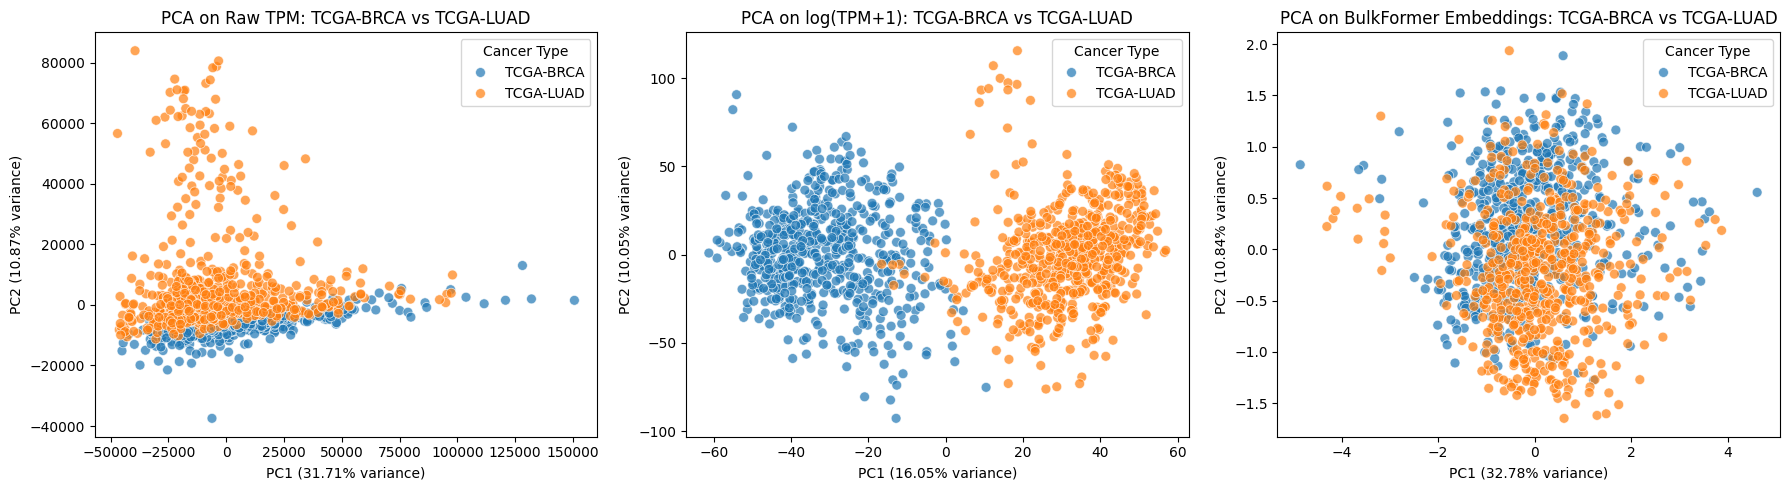


Raw TPM - PC1: 31.71%, PC2: 10.87%
log(TPM+1) - PC1: 16.05%, PC2: 10.05%
BulkFormer Embeddings - PC1: 32.78%, PC2: 10.84%


In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt

# Define high variance genes and valid gene indices (using all genes)
high_var_gene_idx = list(range(len(canonical_order)))
valid_gene_idx = list(range(len(canonical_order)))

# Extract embeddings for the balanced subset
sample_embs_subset = extract_feature(
	expr_array=X_sub,
	high_var_gene_idx=high_var_gene_idx,
	feature_type='transcriptome_level',
	aggregate_type='max',
	device=device,
	batch_size=4,
	model=model,
	return_expr_value=False,
	esm2_emb=gene_emb,
	valid_gene_idx=valid_gene_idx
).numpy()

# Perform PCA on sample embeddings
pca_emb = PCA(n_components=2)
X_pca_emb = pca_emb.fit_transform(sample_embs_subset)

# Create labels for the balanced subset
labels = [A] * n + [B] * n

# Create a 3-panel comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Raw TPM PCA
sns.scatterplot(x=X_pca_raw[:, 0], y=X_pca_raw[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[0])
axes[0].set_xlabel(f'PC1 ({pca_raw.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_raw.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'PCA on Raw TPM: {A} vs {B}')
axes[0].legend(title='Cancer Type')

# Plot 2: log(TPM+1) PCA
sns.scatterplot(x=X_pca_log[:, 0], y=X_pca_log[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[1])
axes[1].set_xlabel(f'PC1 ({pca_log.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_log.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title(f'PCA on log(TPM+1): {A} vs {B}')
axes[1].legend(title='Cancer Type')

# Plot 3: Sample Embedding PCA
sns.scatterplot(x=X_pca_emb[:, 0], y=X_pca_emb[:, 1], hue=labels, alpha=0.7, s=50, ax=axes[2])
axes[2].set_xlabel(f'PC1 ({pca_emb.explained_variance_ratio_[0]:.2%} variance)')
axes[2].set_ylabel(f'PC2 ({pca_emb.explained_variance_ratio_[1]:.2%} variance)')
axes[2].set_title(f'PCA on BulkFormer Embeddings: {A} vs {B}')
axes[2].legend(title='Cancer Type')

plt.tight_layout()
plt.show()

print(f"\nRaw TPM - PC1: {pca_raw.explained_variance_ratio_[0]:.2%}, PC2: {pca_raw.explained_variance_ratio_[1]:.2%}")
print(f"log(TPM+1) - PC1: {pca_log.explained_variance_ratio_[0]:.2%}, PC2: {pca_log.explained_variance_ratio_[1]:.2%}")
print(f"BulkFormer Embeddings - PC1: {pca_emb.explained_variance_ratio_[0]:.2%}, PC2: {pca_emb.explained_variance_ratio_[1]:.2%}")

In [37]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import umap

# -------------------------------------------------------
# 1. Load your sample embeddings + labels
# -------------------------------------------------------
# embeddings: [N_samples, D] → from res1 or AE latent or BulkFormer sample embedding
embeddings = res1  # <-- BulkFormer sample-level embeddings (320-d)

# labels: list/array of disease types or cancer types
labels = np.array(sample_labels)  # e.g., ["BRCA", "BRCA", "LUAD", ...]

print("Embeddings shape:", embeddings.shape)
print("Unique classes:", np.unique(labels))
print()

# -------------------------------------------------------
# 2. PCA → reduce to 64 dims (like paper: dimensionality matching)
# -------------------------------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(embeddings)

pca = PCA(n_components=64, random_state=42)
X_pca = pca.fit_transform(X)

print("PCA output:", X_pca.shape)

# -------------------------------------------------------
# 3. 10-fold cross-validation using Random Forest
# -------------------------------------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)

f1_scores = []

for train_idx, test_idx in kf.split(X_pca):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    f1 = f1_score(y_test, preds, average="weighted")
    f1_scores.append(f1)

print("===================================================")
print(" BulkFormer-based Disease/Cancer Classification")
print("===================================================")
print(f"Weighted F1 (10-fold CV): mean={np.mean(f1_scores):.4f}, std={np.std(f1_scores):.4f}")
print()

# -------------------------------------------------------
# 4. Optional: UMAP visualization (like Fig. 4d)
# -------------------------------------------------------
reducer = umap.UMAP(n_neighbors=30, min_dist=0.2, metric="euclidean", random_state=42)
X_umap = reducer.fit_transform(X_pca)

plt.figure(figsize=(8,6))
for cls in np.unique(labels):
    idx = labels == cls
    plt.scatter(X_umap[idx,0], X_umap[idx,1], s=10, label=str(cls), alpha=0.7)

plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left")
plt.title("UMAP of BulkFormer Sample Embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


2025-11-17 17:12:00.339259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-17 17:12:00.428818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-17 17:12:00.454883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-17 17:12:00.619892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

A module that was compiled using NumPy 1.x cannot be

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/walt/miniconda3/envs/esm2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/walt/miniconda3/envs/esm2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/walt/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/walt/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
 

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/walt/miniconda3/envs/esm2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/walt/miniconda3/envs/esm2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/walt/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/walt/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
 

AttributeError: _ARRAY_API not found

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception

In [ ]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

def evaluate_imputation(model, X_tpm, masking_ratio=0.15, device="cuda"):
    """
    Mask gene expression values in log(TPM+1) space,
    perform prediction, and evaluate PCC/SCC on masked genes.
    """

    X = X_tpm.values.copy()   # shape: samples × genes
    N, G = X.shape

    # mask random genes
    mask = np.random.rand(N, G) < masking_ratio
    X_masked = X.copy()
    X_masked[mask] = 0.0

    # run model to predict gene expression
    preds = extract_feature(
        expr_array=X_masked,
        high_var_gene_idx=list(range(G)),
        feature_type='transcriptome_level',
        aggregate_type='max',
        device=device,
        batch_size=16,
        model=model,
        return_expr_value=True  # return expression predictions
    )

    true_vals = X[mask]
    pred_vals = preds[mask]

    pcc = pearsonr(true_vals, pred_vals)[0]
    scc = spearmanr(true_vals, pred_vals)[0]

    return pcc, scc


# ---- Run example imputation test ----
pcc, scc = evaluate_imputation(model, X_tpm)
print("Imputation PCC:", pcc)
print("Imputation Spearman:", scc)


100%|██████████| 218/218 [04:43<00:00,  1.30s/it]


Imputation PCC: 0.8040295377461469
Imputation Spearman: 0.813488145615733


# Gene Embedding Analysis — Summary

This notebook extracts **gene-level embeddings** from the pretrained Performer model, visualizes them with t-SNE, and groups genes using KMeans. These embeddings reflect structure learned from ARCHS4 bulk RNA-seq and are examined across four TCGA samples.

---

## What the t-SNE Map Represents

The t-SNE plot is a **2D projection of all gene embeddings**.

* Genes with similar functional behavior map close together.
* Distant points correspond to functionally unrelated genes.
* Colors show KMeans clusters.

The embedding space integrates:

* expression co-variation
* protein sequence information (ESM2)
* graph-based gene neighborhoods
* cancer-related expression patterns

---

## What the Clusters Capture

Across clusters, we recover consistent biological programs, including:

* oxidative stress and metal-ion handling
* GPCR/sensory signaling
* chromatin and histone modification
* immune and viral response
* metabolic programs (lipids, OXPHOS)

These emerge directly from the model’s learned structure without supervision.

---

## Downstream Tasks Enabled (aligned with the original BulkFormer paper)

**Expression-level tasks**

* Masked-value imputation and quality checks for noisy samples.

**Gene-level tasks**

Here is a tighter version with one-sentence technical explanations added under each bullet:

---

## Downstream Tasks Enabled 

**Gene-level tasks**

* **Predict functional category membership (GO/KEGG).**
  * Train a classifier (e.g., logistic regression or random forest) directly on gene-embedding vectors to predict whether each gene belongs to a given pathway.*

* **Prioritize or annotate uncharacterized genes via cluster membership.**
  * Assign an unannotated gene to its nearest neighbors or KMeans cluster in embedding space and inherit functional signatures from those neighbors.*

* **Build gene-level predictors (essentiality, drug response).**
  * Use each gene’s embedding as input features to an MLP to predict continuous scores such as DepMap essentiality or drug-induced expression changes.*

---


Here is a concise upgrade of your **Sample-level Tasks** section with a clear **technical sub-bullet** and an explicit link to **precision health**, consistent with the tone, structure, and intent of the original paper.

---

## **Sample-level tasks**

* **Build sample embeddings for disease or subtype classification.**
  * Extract final-layer gene embeddings → apply max pooling across genes → produce one vector per sample → feed into PCA + a classifier (e.g., Random Forest).
  These embeddings capture tumor-wide biology and enable accurate disease and subtype prediction.

* **Compare samples via cluster-frequency shifts to highlight active pathways.**
  * For each sample, identify which gene clusters show high activation (mean or max embedding signal); compare these activation profiles across cohorts to detect pathway-level differences.
  This allows characterization of pathway usage (immune, metabolic, proliferative) at the sample level.

* **Apply embeddings to prognosis and precision-health models.**
  * Use sample embeddings as inputs to supervised survival models (Cox regression, random forests) to derive risk scores that integrate signals across all genes—not just known biomarkers.
  This supports precision oncology by improving risk stratification and identifying latent biomarkers that bulk expression alone cannot reveal.


These analyses collectively show how BulkFormer-style gene embeddings encode biological function and can be used for downstream discovery.


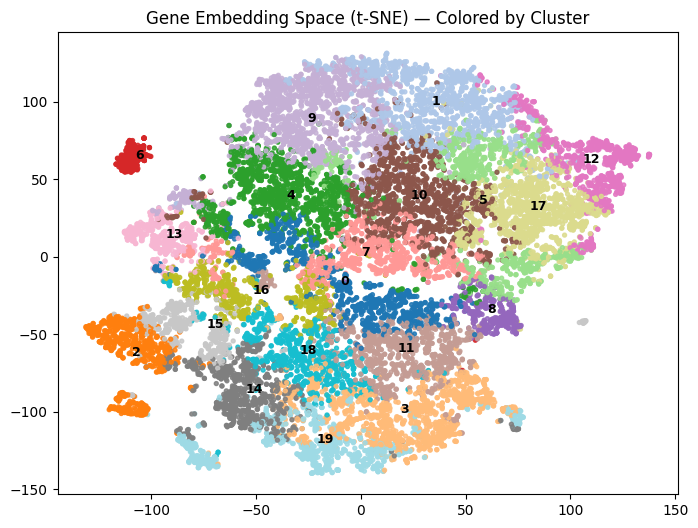


=== Cluster 2 ===
                                                Term  Adjusted P-value
0           sensory perception of smell (GO:0007608)      5.046362e-34
1  sensory perception of chemical stimulus (GO:00...      1.647348e-25
2  detection of chemical stimulus involved in sen...      1.403624e-08
3  detection of chemical stimulus involved in sen...      7.517269e-08
4        chemical synaptic transmission (GO:0007268)      1.875116e-07

=== Cluster 6 ===
                                                Term  Adjusted P-value
0  complement activation, lectin pathway (GO:0001...          0.976736
1   negative regulation of axonogenesis (GO:0050771)          0.976736
2  negative regulation of axon extension (GO:0030...          0.976736
3  negative regulation of developmental growth (G...          0.976736
4   negative regulation of neurogenesis (GO:0050768)          0.976736


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import gseapy as gp

# ------------------------------
# Gene-level embeddings
# ------------------------------
gene_embs = res2.mean(axis=0)  # [n_genes, dim]
gene_names = canonical_order

# ------------------------------
# t-SNE
# ------------------------------
tsne = TSNE(
    n_components=2,
    perplexity=20,
    learning_rate="auto",
    max_iter=2000,
    init="random"
)
coords = tsne.fit_transform(gene_embs)

# ------------------------------
# K-Means
# ------------------------------
K = 20
labels = KMeans(K, random_state=0).fit_predict(gene_embs)

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1], c=labels, cmap="tab20", s=8, alpha=0.85)

for k in range(K):
    cx = coords[labels==k, 0].mean()
    cy = coords[labels==k, 1].mean()
    plt.text(cx, cy, str(k), fontsize=9, weight="bold")

plt.title("Gene Embedding Space (t-SNE) — Colored by Cluster")
plt.show()

# ------------------------------
# GO/KEGG Enrichment per cluster
# ------------------------------
def get_terms(cluster_id, top=5):
    genes = [gene_names[i] for i in np.where(labels == cluster_id)[0]]

    enr = gp.enrichr(
        gene_list=genes,
        gene_sets=["GO_Biological_Process_2021", "KEGG_2021_Human"],
        outdir=None,
    )

    return enr.results[["Term", "Adjusted P-value"]].head(top)

for cid in [2, 6]:
    print(f"\n=== Cluster {cid} ===")
    print(get_terms(cid))


In [ ]:
import gseapy as gp
import numpy as np

# Example: choose one cluster to extract a GO term
cluster_id = 2
genes = cluster_gene_lists[cluster_id]

# Run enrichment
enr = gp.enrichr(
    gene_list=genes,
    gene_sets=["GO_Biological_Process_2021"],
    outdir=None
)

# Pick the top enriched GO term
top_term = enr.results.iloc[0]
term_name = top_term["Term"]

# Get list of genes annotated to that GO term (as returned by Enrichr)
term_genes = top_term["Genes"].split(";")   # Enrichr gives semicolon-separated gene list

# Now construct the pathway label vector
pathway_labels = np.array([
    1 if g in term_genes else 0
    for g in gene_names
], dtype=int)

print("Positive genes in term:", pathway_labels.sum())

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = gene_embs          # [n_genes, dim]
y = pathway_labels     # binary vector created above

clf = LogisticRegression(max_iter=500)
scores = cross_val_score(clf, X, y, cv=10, scoring="average_precision")

print("GO Class Prediction AUPRC:", scores.mean())



Positive genes in term: 47
GO Class Prediction AUPRC: 0.7032158821688057


/home/walt/miniconda3/envs/esm2/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


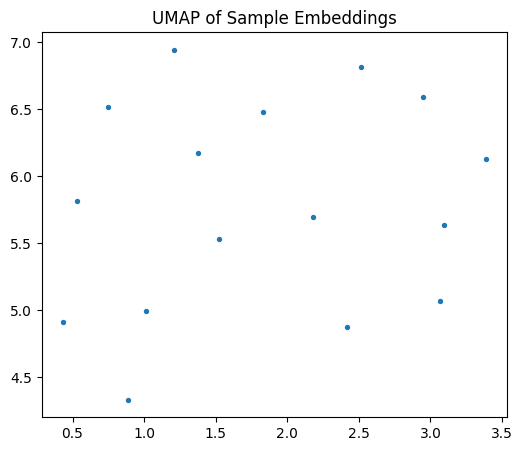

ValueError: Found input variables with inconsistent numbers of samples: [16, 3481]

In [ ]:
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Sample-level embeddings (log(TPM+1) input)
sample_embs = res1.numpy()

# ---- UMAP ----
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1)
umap_coords = reducer.fit_transform(sample_embs)

plt.figure(figsize=(6,5))
plt.scatter(umap_coords[:,0], umap_coords[:,1], s=8)
plt.title("UMAP of Sample Embeddings")
plt.show()

# ---- Classification ----
labels = metadata['project_id']   # from your TCGA mapping
enc = LabelEncoder()
y = enc.fit_transform(labels)

clf = RandomForestClassifier(n_estimators=200)
scores = cross_val_score(clf, sample_embs, y, cv=5, scoring="f1_weighted")

print("Disease-classification F1:", scores.mean())






In [ ]:
print(metadata.columns)
metadata.head()


Index(['file_id', 'project_id', 'tissue_type'], dtype='object')


,file_id,project_id,tissue_type
0,9dc09c86-c728-4bd9-b2b6-2d9962dad662,TCGA-BRCA,Tumor
1,95668f0b-130d-44d4-94c0-ba7a4e7798e6,TCGA-BRCA,Tumor
2,461fda5d-d6e6-4354-b035-c302cc43b03f,TCGA-BRCA,Tumor
3,30ff778c-844b-4140-9025-7ab1938f10a9,TCGA-BRCA,Tumor
4,427a04c9-9b48-49de-8a47-2adc4e1dd32a,TCGA-BRCA,Tumor
